## Nombre: Alex Reinoso
## Materia: Simulacion
## Tema: Examen final practico
## Fecha: 02/26/2022

## Instalar

In [64]:
pip install simpy

# Investigacion

Cantidad de turistas que visitaron Cuenca en el feriado de noviembre de 2021: 90.000
<br>
Cantidad de turistas que visitaron Manta: 100.000,00
<br>
Cantidad de turisistas que visitaron Tungurahua: 20.000,00 la mayoria desde GYE y UIO
  * Banos: 8.000,00 plazas en el hospedaje
  * Ambato: 4.500,00

Fuente: https://dialoguemos.ec/2021/11/sector-turistico-del-pais-se-reactiva-tras-el-feriado/

# Importaciones

In [65]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats 
import seaborn as sns 
import collections
import random 
import simpy
from numpy.core.fromnumeric import size
from scipy.stats import bernoulli, binom

# Variables

In [66]:
CAPACIDAD = 40
NUM_BUSES=10
TIEMPO_SIMULACION = 96 #son 4 dias de feriado y esto hace 96 horas

MEDIA=0.16
DESV_S=0.03
NOMBRES = ['Arnold', 'Charles', 'Tupac','Nicki','Estefania','Alan','Ronal','Nadia','Esteban','Pablo']

#Funciones

In [67]:
def generarGenero(n):
  p = 0.37
  res = []
  for i in range(0,n):
    res += randomBernoulliVariables(p)
  return res

def generarNombre(n):
  res = []
  for i in range(0, n):
    rn = random.randint(0,9)
    res.append(NOMBRES[rn])
  return res

def randomBernoulliVariables(p):
  if np.random.rand() <= p:
    return 'M'
  else:
    return 'F'
def poissonEdades(s):
  rng = np.random.default_rng() 
  arr = rng.poisson(20,s)
  arr = arr[arr > 18]
  if (arr.size < s):
    ar2 = rng.poisson(20,s)
    ar2 = ar2[ar2 > 18]
    res = np.concatenate([arr, ar2])
    if (res.size < s):
      poissonEdades(s)
      return res[0:s]
    else:
      return res[0:s]
  else:
    return arr[0:s]

# Simulacion

In [108]:
import collections
import random
import simpy

def empresa(env,empresaturismo,destino):  
  with empresaturismo.resurso_buses.request() as turno: 
    yield turno
    imprimir_datos_recurso_bus(resurso_buses) # Informacion de los buses
    print('Bus con destino: %s llegara en %.1f horas' %(destino, empresaturismo.horas_destino[destino]))
    yield env.timeout(empresaturismo.horas_destino[destino])
    empresaturismo.resurso_buses.release(turno) 
    print('Bus llego a : %s en %.1f horas' %(destino, empresaturismo.horas_destino[destino]))
    print('Se libera el bus')

def imprimir_datos_recurso_bus(rec):
  print(f'{rec.count} de {rec.capacity}')    

def ventaBoletos(env, num_pasajes, destino, empresaturismo):
  with empresaturismo.recurso_cant_pasajes.request() as turno:
    resultado = yield turno | empresaturismo.sold_out[destino]
    if empresaturismo.num_pasajes[destino] < num_pasajes:
      yield env.timeout(0.5) 
      return
    empresaturismo.num_pasajes[destino] -= num_pasajes
    if empresaturismo.num_pasajes[destino] == 0:
      empresaturismo.num_buses[destino]+=1  
      env.process(empresa(env,empresaturismo,destino))    
      empresaturismo.num_pasajes[destino] = 40
    visitados[destino] +=1

def llegadaPasajeros(env, empresaturismo):
  while True:    
    normal = stats.norm(MEDIA, DESV_S)
    yield env.timeout(normal.rvs(1)) #tiempo de llegado estimado de los pasajeros
    destino = random.choices(empresaturismo.destinos, empresaturismo.probabilidad, k=1)#se selecciona el destino basado en la probabilidad dada, estos datos se toman en base a donde mas visitan los turistas
    num_pasajes = 1
    cantidad = 1#esto es para generar la persona
    generos = generarGenero(cantidad)
    edades = poissonEdades(cantidad)
    nombres = generarNombre(cantidad)
    rslt = zip(nombres, edades, generos)
    res =list(rslt)
    print('Cliente %s con destino a %s' %(res, destino))
    if empresaturismo.num_pasajes[destino[0]]:
      env.process(ventaBoletos(env, num_pasajes, destino[0], empresaturismo)) 
      
ABCTURISMO  = collections.namedtuple('ABCTURISMO', 'recurso_cant_pasajes,resurso_buses,horas_destino,probabilidad,destinos,num_pasajes,sold_out,num_buses')
env = simpy.Environment()

recurso_cant_pasajes = simpy.Resource(env,capacity=1)
resurso_buses = simpy.Resource(env,capacity=NUM_BUSES)
DESTINOS = ['MANTA','GYE','BANOS','AMBATO']
horas_viaje = [11, 5, 7, 9]
probabilidad = [0.45, 0.20, 0.15, 0.20 ]
horas_destino=dict(zip(DESTINOS, horas_viaje))
num_pasajes = {destino: CAPACIDAD for destino in DESTINOS}
sold_out = {destino: env.event() for destino in DESTINOS}
num_buses = {destino: 0 for destino in DESTINOS}
visitados = {destino: 0 for destino in DESTINOS}

abcturismo  = ABCTURISMO (recurso_cant_pasajes, resurso_buses, horas_destino, probabilidad, DESTINOS, num_pasajes, sold_out,num_buses)
env.process(llegadaPasajeros(env, abcturismo))
env.run(until=TIEMPO_SIMULACION)#Aqui le mando el tiempo de 4 dias

print('REPORTE ABC-TURISMO')
for destino in DESTINOS:
  if abcturismo.sold_out[destino]:       
    print('Destino: %s necesita %.1f buses' %(destino, abcturismo.num_buses[destino])) 

Cliente [('Pablo', 19, 'F')] con destino a ['GYE']
Cliente [('Ronal', 30, 'F')] con destino a ['AMBATO']
Cliente [] con destino a ['GYE']
Cliente [('Alan', 23, 'F')] con destino a ['GYE']
Cliente [('Pablo', 22, 'F')] con destino a ['AMBATO']
Cliente [('Estefania', 20, 'M')] con destino a ['MANTA']
Cliente [] con destino a ['BANOS']
Cliente [('Tupac', 21, 'M')] con destino a ['MANTA']
Cliente [('Tupac', 19, 'F')] con destino a ['AMBATO']
Cliente [('Tupac', 19, 'F')] con destino a ['MANTA']
Cliente [('Esteban', 19, 'F')] con destino a ['AMBATO']
Cliente [('Ronal', 26, 'F')] con destino a ['GYE']
Cliente [('Esteban', 24, 'M')] con destino a ['BANOS']
Cliente [] con destino a ['AMBATO']
Cliente [('Charles', 26, 'F')] con destino a ['GYE']
Cliente [] con destino a ['BANOS']
Cliente [('Alan', 21, 'M')] con destino a ['MANTA']
Cliente [('Charles', 19, 'F')] con destino a ['BANOS']
Cliente [('Tupac', 21, 'M')] con destino a ['MANTA']
Cliente [('Alan', 20, 'F')] con destino a ['MANTA']
Cliente 

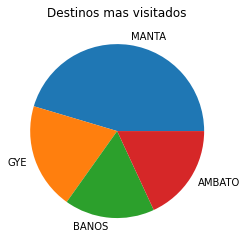

In [109]:
plt.pie(list(visitados.values()), labels=list(visitados.keys()))
plt.title('Destinos mas visitados')
plt.show()

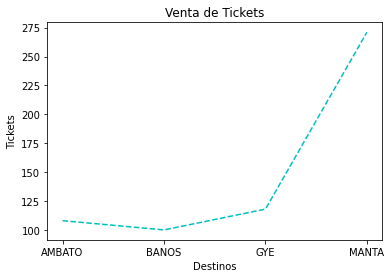

In [110]:
data = visitados.items()
data = sorted(data) 
x, y = zip(*data) 
plt.plot(x, y, 'c--')
plt.title('Venta de Tickets')
plt.xlabel('Destinos')
plt.ylabel('Tickets')
plt.show()

In [111]:
visitados

{'AMBATO': 108, 'BANOS': 100, 'GYE': 118, 'MANTA': 271}

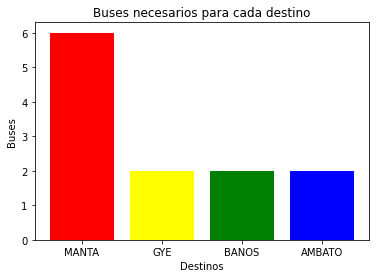

In [112]:
etiqueta = list(num_buses.keys())
valores = list(num_buses.values())
plt.bar(range(len(num_buses)), valores, align="center", tick_label=etiqueta, color=['red', 'yellow', 'green', 'blue', 'cyan'])
plt.title("Buses necesarios para cada destino")
plt.xlabel("Destinos")
plt.ylabel("Buses")
plt.show()